In [1]:
import os
import csv
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from collections import Counter
import pandas as pd
import numpy as np
import random
import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data_dir = 'data'
batch_size = 32
num_epochs = 20
learning_rate = 0.001
log_file = 'logs/training_log.csv'
model_path = 'models/resnet_best.pth'
label_list = ["Normal", "Pneumonia"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA availabe: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU model: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA availabe: True
CUDA version: 12.8
GPU model: NVIDIA GeForce RTX 5060 Ti


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# loda Training data
full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform)
labels = [sample[1] for sample in full_dataset.samples]

# split val dataset & train dataset
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=77)
for i_train, i_val in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, i_train)
    val_dataset = Subset(full_dataset, i_val)
    
# load testing data
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

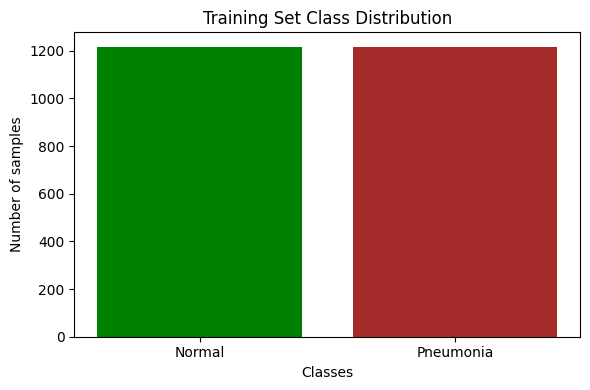

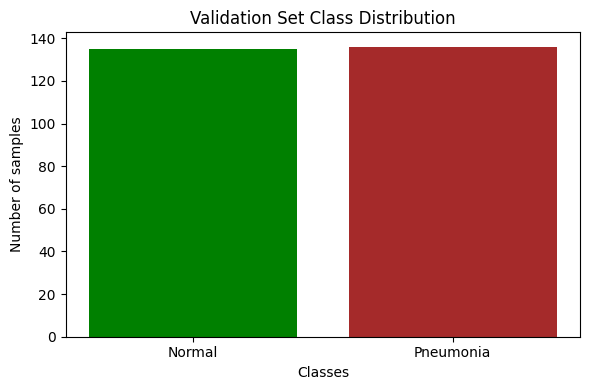

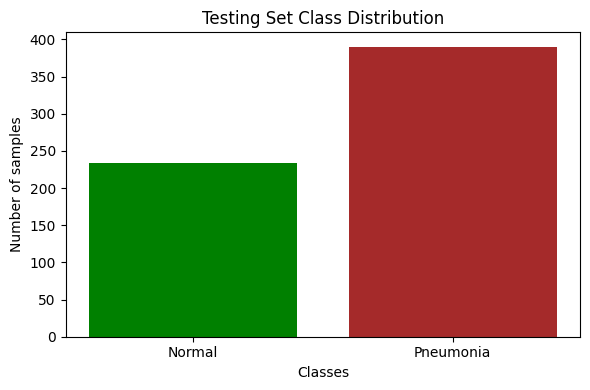

In [4]:
def plot_class_distribution(all_labels, dataset_name):
    label_list = ['Normal', 'Pneumonia']
    class_counts = np.bincount(all_labels, minlength=len(label_list))
    plt.figure(figsize=(6, 4))
    plt.bar(label_list, class_counts, color=['green', 'brown'])
    plt.xlabel('Classes')
    plt.ylabel('Number of samples')
    plt.title(dataset_name+' Class Distribution')
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('data/'+dataset_name+' distribution.jpg')
    plt.show()
plot_class_distribution(np.array(full_dataset.targets)[train_dataset.indices], 'Training Set')
plot_class_distribution(np.array(full_dataset.targets)[val_dataset.indices], 'Validation Set')
plot_class_distribution(np.array(test_dataset.targets), 'Testing Set')

In [5]:
# training
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


In [6]:
best_val_acc = 0.0
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    loop = tqdm((train_loader), total = len(train_loader))
    
    for images, labels in loop:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        pred = (outputs > 0).long()
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().item() * images.size(0)
        correct += (pred.squeeze() == labels).sum().item()
        train_loss = running_loss / len(train_dataset)
        train_acc = correct / len(train_dataset)
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss = train_loss, acc = train_acc)
    

    # validation
    model.eval()
    correct = 0
    val_losses = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            pred = (outputs > 0).long()
            correct += (pred.squeeze() == labels).sum().item()
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_losses += loss.item()
    val_acc = correct / len(val_dataset)
    val_loss = val_losses / len(val_loader)
    # adjust learning rate
    scheduler.step(val_acc)

    # save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

Epoch [20/20]: 100%|█████████████████████████████████████████████| 76/76 [00:53<00:00,  1.43it/s, acc=1, loss=0.000219]


In [7]:
# save training log
log_df = pd.DataFrame({
    'epoch': range(1, num_epochs+1),
    'Train Loss': train_loss_list,
    'Train Acc': train_acc_list,
    'Val Loss': val_loss_list,
    'Val Acc': val_acc_list
})
log_df.to_csv('logs/training_log.csv', index=False)

In [8]:
# Testing
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        preds = (outputs > 0).long().cpu()
        all_preds.extend(preds)
        all_labels.extend(labels)

# classification report
report = classification_report(all_labels, all_preds, target_names=full_dataset.classes, output_dict=True, zero_division=0)
print("\nTesting report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes, zero_division=0))
import pandas as pd
df = pd.DataFrame(report).transpose()
df.to_csv("results/testing report.csv")


Testing report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.65      0.78       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



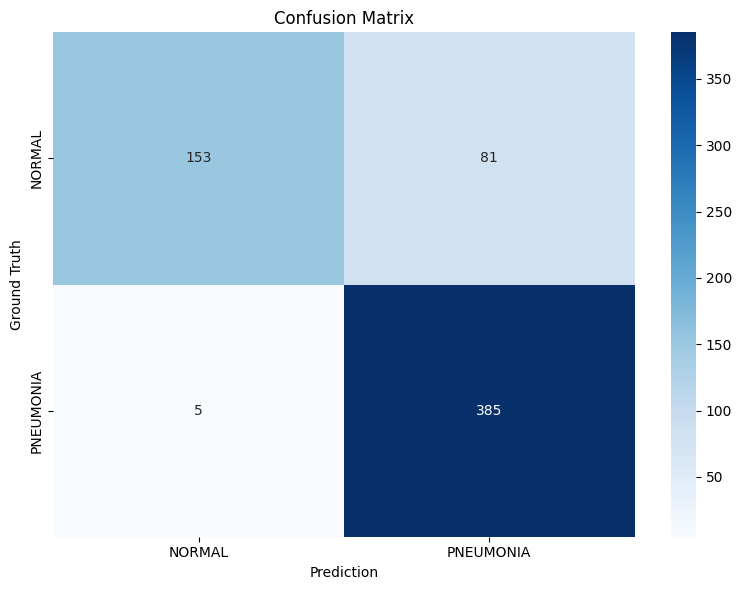

In [9]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('results/confusion_matrix.jpg')
plt.show()

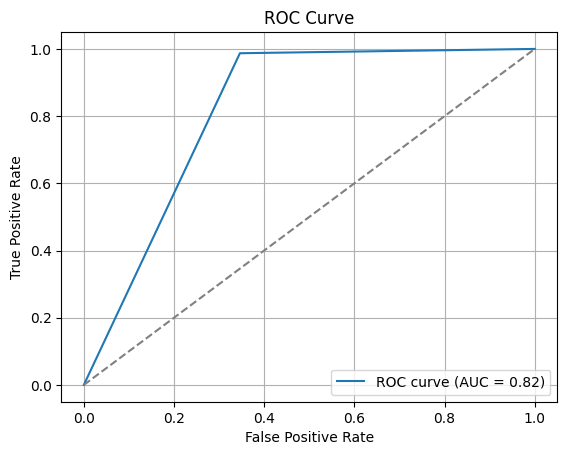

In [10]:
# ROC & AUC
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('results/ROC_curve.jpg')
plt.show()